## Machine Sound Prediction Preprocessing 
Data is From Zenodo, MIMII machine dataset. Main audio used during development was the 0dB pump sound set.

Mainly based on Tutorial at: https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d

Also based off of the Librosa Specshow Docs: https://librosa.org/doc/main/auto_examples/plot_display.html

### Summary
Doing machine learning usually requires a lot of pre-processing of the audio signal, before it is fed to a model. One of the most common ways to do deep learning on audio samples is to convert them into spectrograms, then use a CNN to perform inference on these pictures. This is the method that will be used for this project.

In [2]:
import librosa
import librosa.display

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from IPython.display import Audio

%matplotlib inline

### Initial Data Load and Check

In [11]:
import sys
print(sys.path)
# data_path = '~/ws/dlp_ws/dlp_final'
# ls /data/6_dB_fan/fan/id_00/abnormal/00000001.wav

['/home/ncrl/ws/dlp_ws/dlp_final/.ipynb_checkpoints', '', '/opt/ros/melodic/lib/python2.7/dist-packages', '/home/ncrl/anaconda3/envs/dlp/lib/python39.zip', '/home/ncrl/anaconda3/envs/dlp/lib/python3.9', '/home/ncrl/anaconda3/envs/dlp/lib/python3.9/lib-dynload', '/home/ncrl/anaconda3/envs/dlp/lib/python3.9/site-packages']


In [21]:
normal_audio_path = '/home/ncrl/ws/dlp_ws/dlp_final/data/6_dB_fan/fan/id_00/normal/00000001.wav'
abnormal_audio_path = '/home/ncrl/ws/dlp_ws/dlp_final/data/6_dB_fan/fan/id_00/abnormal/00000001.wav'

y1 , sr1 = librosa.load(normal_audio_path)
y2 , sr2 = librosa.load(abnormal_audio_path)

#print(type(x), type(sr),)
print(f"\nWav file array shape is: {y1.shape}\nsampling rate is: {sr1}")
y = y1
sr = sr1


Wav file array shape is: (220500,)
sampling rate is: 22050


### Audio Inspection
- there seems to be a very obvious audible difference in between *normal* and *abnormal*. At least among the 0dB pump samples I listened to.
- the entire 10 seconds shouldn't be necessary to classify between normal/broken.
- default sampling rate seems good.

In [17]:
Audio(normal_audio_path, rate=sr1)

In [18]:
Audio(abnormal_audio_path, rate=sr2)

In [19]:
print(f"{normal_audio_path} clip is", librosa.get_duration(y=y1, sr=sr1), "seconds long.")
print(f"{abnormal_audio_path} clip is", librosa.get_duration(y=y2, sr=sr2), "seconds long.")

/home/ncrl/ws/dlp_ws/dlp_final/data/6_dB_fan/fan/id_00/normal/00000001.wav clip is 10.0 seconds long.
/home/ncrl/ws/dlp_ws/dlp_final/data/6_dB_fan/fan/id_00/abnormal/00000001.wav clip is 10.0 seconds long.


### Basic Waveforms

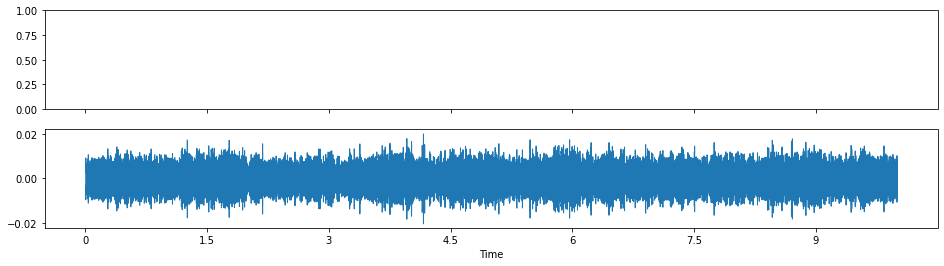

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 4))

#display waveforms?
librosa.display.waveshow(y, sr=sr)

### Spectrogram Subplots for Normal and Abnormal Machine Operation

#### STFT (log scale)
Form spectrograms by computing the DFT over short overlapping frames of the signal, and plotting them. This *normal* spectrogram function uses a log scale.
- n_fft: windowed signal length. 2048 for music, 512 for speech apparently. Machine sounds like percussion, but may change as fast as speech does. Window size is trade off between time resolution versus frequency resolution. Going to lean towards this problem being more like detecting speech events, anomalies.
- window: window function, **need more information on this**.

In [23]:
# STFTs of y
D1 = librosa.stft(y1, n_fft=512, window='hann') 
D2 = librosa.stft(y2, n_fft=512, window='hann')
S_db1 = librosa.amplitude_to_db(np.abs(D1), ref=np.max)
S_db2 = librosa.amplitude_to_db(np.abs(D2), ref=np.max)

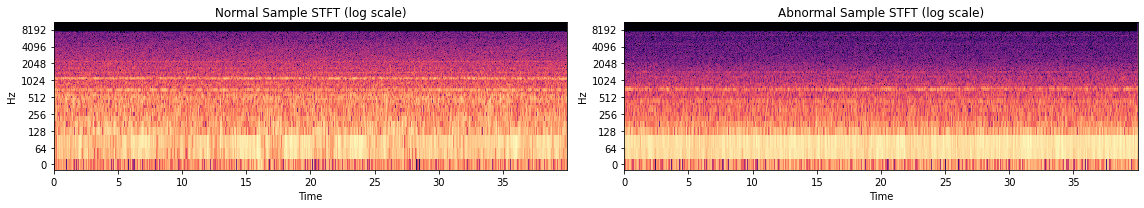

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(16, 3))

img1 = librosa.display.specshow(S_db1, x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Normal Sample STFT (log scale)')
img2 = librosa.display.specshow(S_db2, x_axis='time', y_axis='log', ax=ax[1])
ax[1].set(title='Abnormal Sample STFT (log scale)')
plt.tight_layout()

#### Melspectrogram
Popular choice in ML. A spectrogram that uses the mel scale, to try and reflect how humans perceive pitch. Window size seems to have a very clear effect on picture sharpness for these spectrograms.

In [25]:
M1 = librosa.feature.melspectrogram(y=y1, n_fft=2048, sr=sr)
M2 = librosa.feature.melspectrogram(y=y2, n_fft=2048, sr=sr)
M_db1 = librosa.power_to_db(M1, ref=np.max)
M_db2 = librosa.power_to_db(M2, ref=np.max)

M1_512 = librosa.feature.melspectrogram(y=y1, n_fft=512, sr=sr)
M2_512 = librosa.feature.melspectrogram(y=y2, n_fft=512, sr=sr)
M_db1_512 = librosa.power_to_db(M1_512, ref=np.max)
M_db2_512 = librosa.power_to_db(M2_512, ref=np.max)

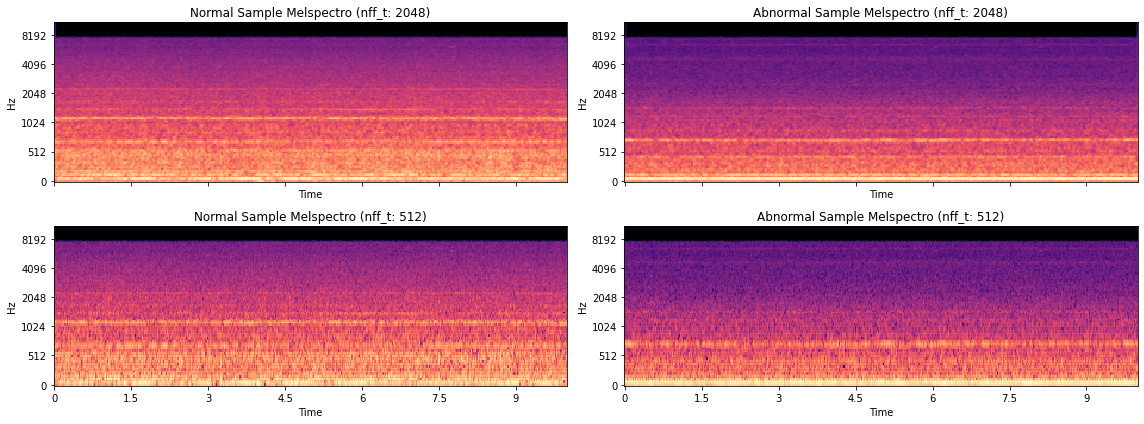

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(16, 6))

img1 = librosa.display.specshow(M_db1, x_axis='time', y_axis='mel', ax=ax[0][0])
ax[0][0].set(title='Normal Sample Melspectro (nff_t: 2048)')
img2 = librosa.display.specshow(M_db2, x_axis='time', y_axis='mel', ax=ax[0][1])
ax[0][1].set(title='Abnormal Sample Melspectro (nff_t: 2048)')

img1 = librosa.display.specshow(M_db1_512, x_axis='time', y_axis='mel', ax=ax[1][0])
ax[1][0].set(title='Normal Sample Melspectro (nff_t: 512)')
img2 = librosa.display.specshow(M_db2_512, x_axis='time', y_axis='mel', ax=ax[1][1])
ax[1][1].set(title='Abnormal Sample Melspectro (nff_t: 512)')

plt.tight_layout()

#### MFCCS
Mel-frequency cepstral coefficients. Aparrently these aren't as resistant to noise, which could be a problem here. The subplot below compares different dct function types being used. It's hard to tell with a human eye if these are more useful for classification.

In [28]:
# comparing dct types
mfccs1_1 = librosa.feature.mfcc(y=y1, sr=sr, dct_type=1)
mfccs2_1 = librosa.feature.mfcc(y=y2, sr=sr, dct_type=1)

mfccs1_2 = librosa.feature.mfcc(y=y1, sr=sr, dct_type=2)
mfccs2_2 = librosa.feature.mfcc(y=y2, sr=sr, dct_type=2)

mfccs1_3 = librosa.feature.mfcc(y=y1, sr=sr, dct_type=3)
mfccs2_3 = librosa.feature.mfcc(y=y2, sr=sr, dct_type=3)

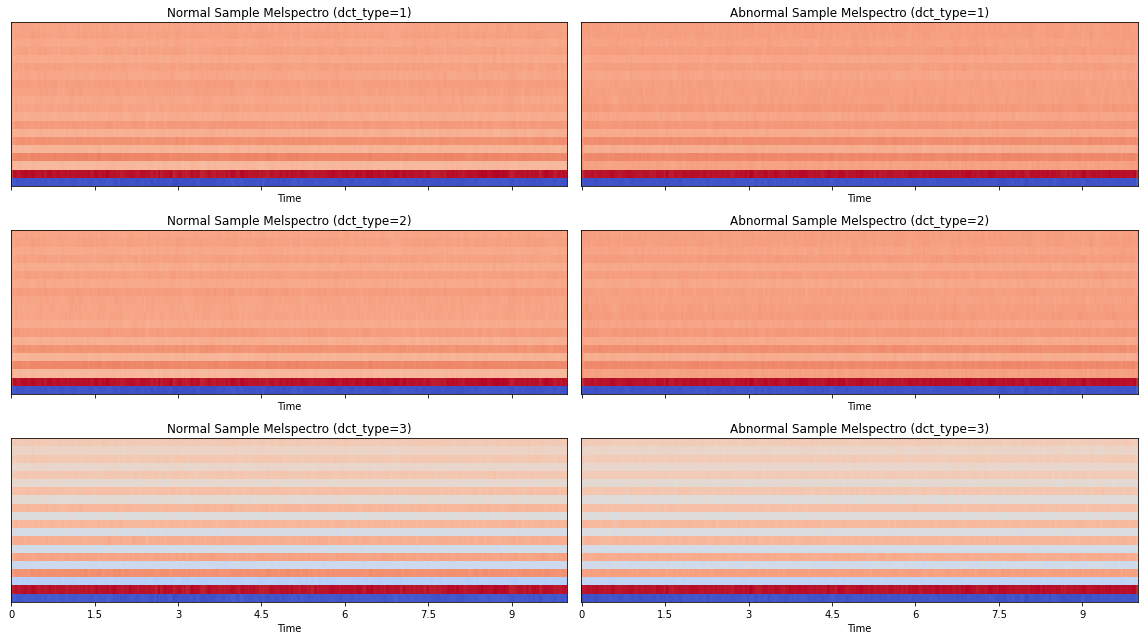

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(16, 9))

img1 = librosa.display.specshow(mfccs1_1, x_axis='time', ax=ax[0][0])
ax[0][0].set(title='Normal Sample Melspectro (dct_type=1)')
img2 = librosa.display.specshow(mfccs2_1, x_axis='time', ax=ax[0][1])
ax[0][1].set(title='Abnormal Sample Melspectro (dct_type=1)')

img1 = librosa.display.specshow(mfccs1_2, x_axis='time', ax=ax[1][0])
ax[1][0].set(title='Normal Sample Melspectro (dct_type=2)')
img2 = librosa.display.specshow(mfccs2_2, x_axis='time', ax=ax[1][1])
ax[1][1].set(title='Abnormal Sample Melspectro (dct_type=2)')

img1 = librosa.display.specshow(mfccs1_3, x_axis='time', ax=ax[2][0])
ax[2][0].set(title='Normal Sample Melspectro (dct_type=3)')
img2 = librosa.display.specshow(mfccs2_3, x_axis='time', ax=ax[2][1])
ax[2][1].set(title='Abnormal Sample Melspectro (dct_type=3)')
plt.tight_layout()

### Choose Spectrogram
- Will the different cmaps make a difference?

In [30]:
Y = librosa.stft(y) # short time Ft
Ydb = librosa.amplitude_to_db(abs(Y)) # does dB scaling of the spectro
M = librosa.feature.melspectrogram(y=y1, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)

Turns out librosa has a amp to dB scaling func for the spectrogram

#### Normal Librosa Spectrogram 

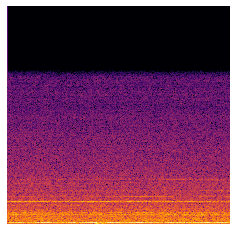

In [31]:
#display Spectrogram
plt.figure(figsize=(4, 4))
plt.axis('off')
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz',cmap='inferno') 

#### Log Spectrogram

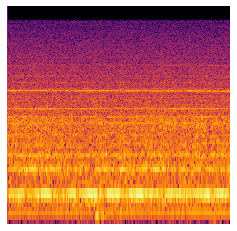

In [32]:
fig = plt.figure(figsize=(4, 4))
plt.axis('off')
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='log', cmap='inferno')

#### MFCCS

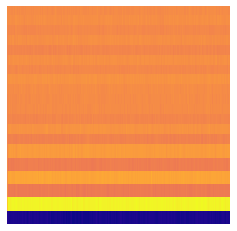

In [33]:
fig = plt.figure(figsize=(4, 4))
mfccs = librosa.feature.mfcc(y=y, sr=sr)
#print(mfccs.shape) #Displaying  the MFCCs:
plt.axis('off')
librosa.display.specshow(data=mfccs, sr=sr, x_axis='time', y_axis='mel', cmap='plasma')

#### Save Spectrograms Func
- convert images from one pump to spectro

In [35]:
# load wav
audio_path = '/home/ncrl/ws/dlp_ws/dlp_final/data/6_dB_fan/fan/id_00/normal/00000000.wav'
y , sr = librosa.load(audio_path)

In [37]:
# create the the actual spectro figure
fig = plt.figure(figsize=(4, 4))
plt.axis('off')
mfccs = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(data=mfccs, sr=sr, x_axis='time', cmap='plasma')

# save

path = '/home/ncrl/ws/dlp_ws/dlp_final/image-data'
os.makedirs(path, exist_ok=False)
fig.savefig(path+'/spec1.png')
plt.close()

In [38]:
# count the files in both folders
# 4211 cli
time_est = (104 / 1000) * 4211 / 60
n = 2
print('Compute time estimate is {time_est:.{digits}f} minutes.'.format(time_est=time_est, digits=n))

Compute time estimate is 7.30 minutes.


#### Full Spectrogram Plot and Save Script

In [55]:
import sys
import os

In [89]:
# get file names
abnormal0_folder = "audio-data/pump/id_00/abnormal"

In [90]:
# get file count
_, _, files = next(os.walk(abnormal0_folder))
file_count = len(files)

Selecting the pump ID from the input directory

In [12]:
import re

In [13]:
!ls audio-data/pump/id_00/abnormal/00000002.wav

audio-data/pump/id_00/abnormal/00000002.wav


In [38]:
test_str = "audio-data/pump/id_02/abnormal/00000002.wav"

regex_pattern = r'id_\d{2}'
pump_id = re.search(regex_pattern, test_str).group(0)

print(pump_id)

id_02
